# Kernel Density Estimation

A density estimator takes a $D$-dimensional dataset and returns an estimate of the $D$-dimensional probability distribution from that data. GMM does this by representing the density as a weighted sum of Gaussian distributions.

__Kernel density estimation__ (KDE) is process that takes the mixture-of-Gaussians idea to its logical extreme: it __uses a mixture consisting of one Gaussian component per point__, resulting in an essentially non-parametric estimator of density.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Histograms

Histograms are __1-dimensional density estimators__. They divide data into discrete bins, counts the number of points in each bin, then plot the results in an intuitive manner.

In [32]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)
x[:10]

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038])

In [33]:
x.shape

(1000,)

A standard histogram can be created with ``plt.hist()``. The ``normed`` parameter gives us a normalized histogram. __(The bin heights instead reflect probability densities)__.

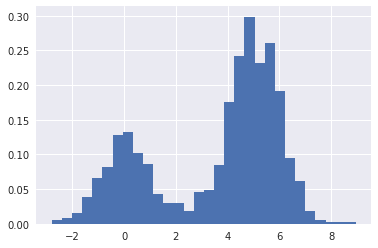

In [34]:
hist = plt.hist(x, bins=30, normed=True)

Normalization sets the total area under the histogram = 1.

In [35]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

Using a histogram as a density estimator can be problematic. The choice of bin size and location can lead to misleading representations.

In [36]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

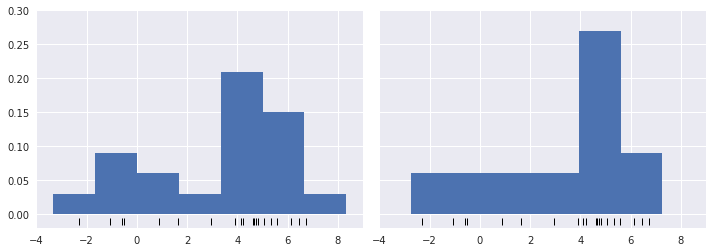

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

__On the left__: this is a bimodal distribution. 

__On the right__: this is a unimodal distribution with a long tail.

This was generated from the same code. So how do you trust them?

(-0.2, 8)

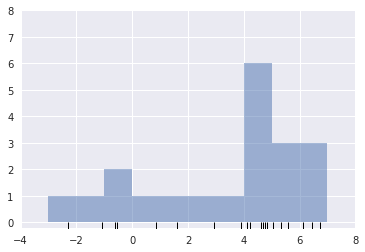

In [38]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The height of the block stack often reflects not the actual density of points nearby, but on coincidences of how the bins align with the data points.

What if, instead of stacking the blocks aligned with the *bins*, we __stack the blocks with the *points they represent*__? The blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.

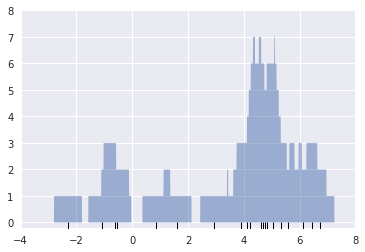

In [39]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result (using a __fill_between__ plot) looks messy but is a more robust reflection of the data. To smooth out the edges we could replace the blocks  with a smooth function like a Gaussian. __Let's use a standard normal curve at each point instead of a block.__

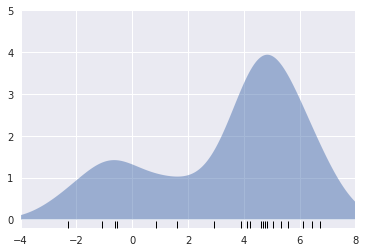

In [40]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

The Gaussian distribution contributed at the location of each input point gives a more accurate idea of the shape of the distribution - and has less variance.

The last two plots are examples of kernel density estimation in one dimension: the __first uses a so-called "tophat" kernel__; the __second uses a Gaussian kernel__. We'll now look at kernel density estimation in more detail.

### Kernel Density Estimation in Practice

KDE parameters include the *kernel* (the shape of the distribution at each point) and the *kernel bandwidth* (the size of the kernel at each point).

Scikit's [KDE class](http://scikit-learn.org/stable/modules/density.html) supports six kernels.

KDE can be __computationally intensive__. Scikit estimator uses a tree-based algorithm and can __trade computation time for accuracy__ using the ``atol`` (absolute tolerance) and ``rtol`` (relative tolerance) parameters.

The kernel bandwidth can be found using a standard cross validation tool.

Replicate the above plot using Scikit's ``KernelDensity`` estimator:

(-0.02, 0.22)

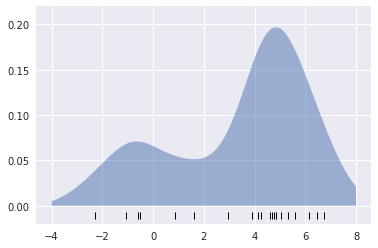

In [41]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

### Selecting the bandwidth via cross-validation

__KDE bandwidth__ is the knob that controls the bias–variance trade-off. A narrow bandwidth leads to a high-variance estimate (over-fitting), where the presence or absence of a single point makes a large difference. 

A wide bandwidth leads to a high-bias estimate (under-fitting) where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

SciKit's ``KernelDensity`` estimator is designed such that it can be used  with Scikit's standard grid search tools. Here we will use ``GridSearchCV`` to optimize the bandwidth.

We are using a very small dataset. So let's use __leave-one-out cross-validation__, which minimizes the reduction in training set size for each trial.

In [42]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

In [43]:
x

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  6.74481176,  4.2387931 ,  5.3190391 ,  4.75062962,
        6.46210794,  2.93985929,  4.6775828 ,  4.61594565,  6.13376944,
        3.90010873,  4.82757179,  4.12214158,  5.04221375,  5.58281521])

In [27]:
kd = KernelDensity(kernel='gaussian')
cv = LeaveOneOut()

In [54]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
#bandwidths = np.logspace(-1,1,20)

#grid = GridSearchCV(kd,{'bandwidth': bandwidths},cv)
grid = GridSearchCV(kd,{'bandwidth': bandwidths})

In [57]:
grid.fit(x[:,None]);

Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

In [58]:
grid.best_params_

{'bandwidth': 3.4304692863149193}

### Example: KDE on a Sphere

Let's use geographic data the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the Brown-throated Sloth) and *Microryzomys minutus* (the Forest Small Rice Rat). Fetch the dataset with Scikit.

In [59]:
from sklearn.datasets import fetch_species_distributions
import numpy as np

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

Use the Basemap toolkit to plot the locations of these two species on the map of South America.

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/bjpcjp/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/bjpcjp/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/bjpcjp/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


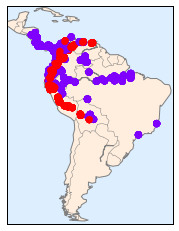

In [60]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())

m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

This doesn't describe density of the species, because points in the species range may overlap one another.

Use KDE to show this distribution as a smooth indication of density on the map. __The coordinate system here lies on a spherical surface rather than a flat plane. Use the ``haversine`` distance metric, which represents distances on a curved surface.__

There is a bit of boilerplate code here (one of the disadvantages of the Basemap toolkit) but the meaning of each code block should be clear:

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


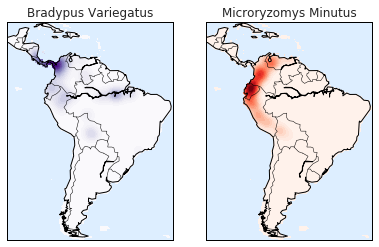

In [61]:
import matplotlib.pyplot as plt

# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

Much better.

### Example: Not-So-Naive Bayes

This example uses Bayesian generative classification with KDE, and demonstrates how to use Scikit to create a custom estimator.

With a density estimation algorithm like KDE, we can remove the "naive" element from a Naive Bayes model and perform the same classification with a more sophisticated generative model for each class. Here's the approach:

1. Split the training data by label.

2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.
   
3. From the number of examples of each class in the training set, compute the *class prior*, $P(y)$.

4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$. The class which maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is using Scikit to apply the grid search and cross-validation tasks.

In [62]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth (float): the kernel bandwidth within each class
    kernel (str): the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### The anatomy of a custom estimator

Scikit estimators are classes. It's best for this class to inherit from ``BaseEstimator`` class and the appropriate mixin, which provides standard functionality.

``BaseEstimator`` contains the logic to clone/copy an estimator for a cross-validation procedure. ``ClassifierMixin`` defines a default ``score()`` method used by such routines.

__Next comes the class initialization method:__

```python
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

This is executed when the object is instantiated with ``KDEClassifier()``.

In Scikit, it is important that __initialization contains no operations other than assigning the passed values by name to ``self``.__

This is due to the logic contained in ``BaseEstimator`` required for cloning and modifying estimators for cross-validation, grid search, and other functions.

All arguments to ``__init__`` should be explicit. __``*args`` or ``**kwargs`` should be avoided__ - they will not be correctly handled within cross-validation routines.

__We'll handle training with ``fit()``:__

```python 
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

Here we find the unique classes in the training data, train a ``KernelDensity`` model for each class, and compute the class priors based on the number of input samples.

``fit()`` should always return ``self`` so that we can chain commands. For example:
```python
label = model.fit(X, y).predict(X)
```

Each persistent result of the fit is stored with a trailing underscore (e.g., ``self.logpriors_``).

This is a SciKit convention - you can scan the members of an estimator (using IPython's tab completion) and see which members are fit to training data.

__Here is the prediction logic.__
```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```

Because this is a probabilistic classifier, we first implement ``predict_proba()``. It returns an array of class probabilities of shape ``[n_samples, n_classes]``.

Each ``[i, j]`` of this array is the posterior probability that sample ``i`` is a member of class ``j``, computed by multiplying the likelihood by the class prior and normalizing.

Finally, the ``predict()`` method uses these probabilities and simply returns the class with the largest probability.

### Using our custom estimator

Load the digits dataset & find the cross-validation score for a range of candidate bandwidths using the ``GridSearchCV`` meta-estimator.

In [63]:
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

__Plot the cross-validation score as a function of bandwidth:__

{'bandwidth': 7.0548023107186433}
accuracy = 0.9666110183639399


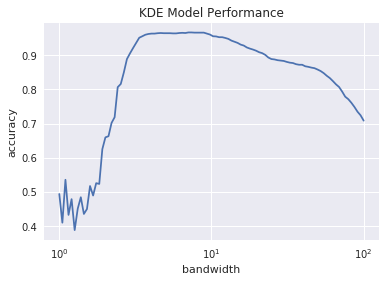

In [64]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.81860038035501381

One advantage of generative classifiers is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a *full model* of the distribution of points we are comparing it to!

Here are some potential improvements:

- we could allow the bandwidth in each class to vary independently
- we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from ``KernelDensity`` itself rather than the global prediction accuracy)